In [92]:
# TODO: Merge these imports into the cells where they are used. 
# %pip install scikit-learn
# %pip install numpy
# %pip install pandas
# %pip install pyaqsapi
# %pip install certifi
# %pip install requests
import os
# from glob import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# import typing as t
# import pyaqsapi as aqs
# from datetime import date
# from functools import reduce

In [93]:
beaco2n_df = pd.read_csv("./BEACO2N_measurements/myron.csv")
aqs_df = pd.read_csv("./reference_measurements/aqs_myron.csv")


def clean_BEACO2N(df: pd.DataFrame) -> pd.DataFrame :
    # Store time in Pandas datetime format.
    df.rename(columns={"datetime":"timestamp", "co2_raw":"co2"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.round("h")

    # Drop redundant time columns
    df.drop(columns=["local_timestamp", "epoch", "node_file_id", "node_id"], inplace=True)
    
    # For all columns suffixed by "_wrk_aux", convert from Volts to milliVolts (*1000) and remove suffix
    wrk_aux_cols = df.filter(regex=r"_wrk_aux$").columns
    df[wrk_aux_cols] *= 1000
    df.rename(columns= {col : col.replace("_wrk_aux", "") for col in wrk_aux_cols}, inplace=True)
    
    # Drop all datapoints with incomplete data (e.g. missing co measurement)
    df.dropna(inplace=True)
    df.set_index("timestamp")
    return df

def clean_aqs(df: pd.DataFrame) -> pd.DataFrame :
    df.rename(columns={"sample_measurement" : "co"}, inplace=True)
    df["timestamp"] = df["date_gmt"] + ' ' + df["time_gmt"]
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True) # should already be hourly, don't need to round.
    df.drop(columns=[col for col in df.columns if col not in ["co", "timestamp"]], inplace=True)
    df = df[["timestamp", "co"]]

    df.dropna(inplace=True)
    df.set_index("timestamp")
    return df

beaco2n_df = clean_BEACO2N(beaco2n_df)
beaco2n_df.drop(columns=[col for col in beaco2n_df.columns if col not in ["timestamp", "co", "temp", "rh"]], inplace=True)
aqs_df = clean_aqs(aqs_df)
merged_df = pd.merge(beaco2n_df, aqs_df, how='inner', on='timestamp', suffixes=["_meas", "_aqs"]).set_index("timestamp")

NOTE: I am assuming the conversion between BEACO2N output and RIDEM output is a coefficient. If the terms are non-linear then this method will not work accurately. 

In [94]:
from sklearn.preprocessing import MinMaxScaler
model = LinearRegression()

y_train: pd.Series
y_test: pd.Series
X_train: pd.DataFrame
X_test: pd.DataFrame

# merged_df['co_meas'] = MinMaxScaler().fit_transform(merged_df[['co_meas']])

y_train, y_test, X_train, X_test = train_test_split(merged_df['co_aqs'], merged_df[['co_meas','temp','rh']], random_state=0)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index).sort_index()
y_test.sort_index().to_csv('./model_predictions/myron/true/myron_aqs.csv')
y_pred.to_csv('./model_predictions/myron/pred/myron_beaco2n_pred.csv')
X_test['co_meas'].to_csv("./model_predictions/myron/raw/myron_beaco2n_raw.csv")

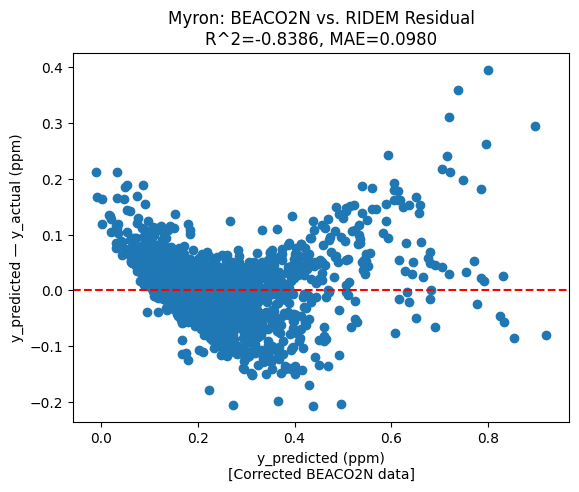

In [95]:
from sklearn.metrics import r2_score, mean_absolute_error
plot = plt.scatter(y_pred, y_test - y_pred)
# xmin, xmax = plt.xlim()
# plt.plot([xmin, xmax],[0,0],color='red',linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
statistics = []
statistics = {
    "Determination R^2" : r2_score(y_test, y_pred),
    "Correlation r" : np.corrcoef(y_test, y_pred)[0,1], 
    "RMSE" : np.sqrt(np.mean((y_test-y_pred)**2)), 
    "MAE" : mean_absolute_error(y_test, y_pred), 
    "Intercept" : model.intercept_,
    "co_coef" : model.coef_[0],
    "temp_coef" : model.coef_[1],
    "rh_coef" : model.coef_[2], 
    'n' : len(y_test) 
}
plt.title(f"Myron: BEACO2N vs. RIDEM Residual\nR^2={statistics['Determination R^2']:.4f}, MAE={statistics['MAE']:.4f}")
plt.xlabel("y_predicted (ppm)\n[Corrected BEACO2N data]")
plt.ylabel("y_predicted — y_actual (ppm)")
plt.savefig("./model_predictions/myron/predicted_vs_true.png")
pd.DataFrame(statistics, index=[1]).T.to_csv("./model_predictions/myron/model_stats.csv")

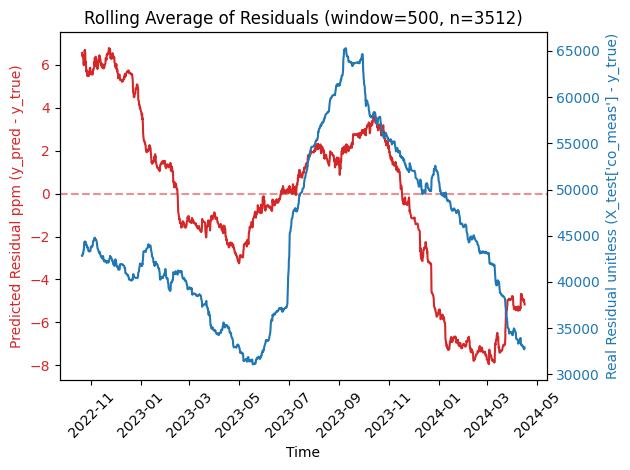

In [96]:
window = 500

pred_residual_vec = (y_pred - y_test)
real_residual_vec = (X_test['co_meas']-y_test)
pred_residual_vec.sort_index(inplace=True)
real_residual_vec.sort_index(inplace=True)

pred_residual_rolling = pred_residual_vec.rolling(window=window).sum()
real_residual_rolling = real_residual_vec.rolling(window=window).sum()

# plt.plot(pred_residual_rolling, color='tab:red')
# plt.title(f"Rolling average (window={window}):\nPredicted Residual (y_pred - y_true)")
# plt.xlabel("Time")
# plt.ylabel("Rolling average (ppm)")
# # plt.figure(figsize=(10,5))
# plt.xticks(rotation=45)
# plt.axhline(color='tab:red', linestyle='--')
# plt.show()

# plt.plot(real_residual_rolling)
# plt.title(f"Rolling average (window={window}):\nReal Residual (X_test['co_meas'] - y_true)")
# plt.xlabel("Time")
# plt.ylabel("Rolling average (unitless)")
# # plt.figure(figsize=(10,5))
# plt.xticks(rotation=45)
# plt.show()

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel("Time")
ax1.set_ylabel("Predicted Residual ppm (y_pred - y_true)", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(color=color, linestyle='--', alpha=0.5)
ax1.plot(pred_residual_rolling, color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("Real Residual unitless (X_test['co_meas'] - y_true)", color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax1.axhline(color=color)
ax2.plot(real_residual_rolling, color=color)

# plt.xticks(rotation=45)
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.title(f"Rolling Average of Residuals (window={window}, n={len(pred_residual_rolling)})")

fig.tight_layout()
plt.savefig("./model_predictions/myron/rolling_avg_residual_combined.png")

In [97]:
# Make a model from beginning to 2023-05.
time_1 = '2023-05-01 00:00:00'
time_2 = '2023-11-01 00:00:00'

X_train_1 = X_train[X_train.index < time_1]
X_test_1 = X_test[X_test.index < time_1]
y_train_1 = y_train[y_train.index < time_1]
y_test_1 = y_test[y_test.index < time_1]
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)
y_pred_1 = pd.Series(model_1.predict(X_test_1), index=X_test_1.index).sort_index()

X_train_2 = X_train[X_train.index >= time_1]
X_train_2 = X_train_2[X_train_2.index < time_2]
X_test_2 = X_test[X_test.index >= time_1]
X_test_2 = X_test_2[X_test_2.index < time_2]
y_train_2 = y_train[y_train.index >= time_1]
y_train_2 = y_train_2[y_train_2.index < time_2]
y_test_2 = y_test[y_test.index >= time_1]
y_test_2 = y_test_2[y_test_2.index < time_2]
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
y_pred_2 = pd.Series(model_2.predict(X_test_2), index=X_test_2.index).sort_index()

X_train_3 = X_train[X_train.index >= time_2]
X_test_3 = X_test[X_test.index >= time_2]
y_train_3 = y_train[y_train.index >= time_2]
y_test_3 = y_test[y_test.index >= time_2]
model_3 = LinearRegression()
model_3.fit(X_train_3, y_train_3)
y_pred_3 = pd.Series(model_3.predict(X_test_3), index=X_test_3.index).sort_index()

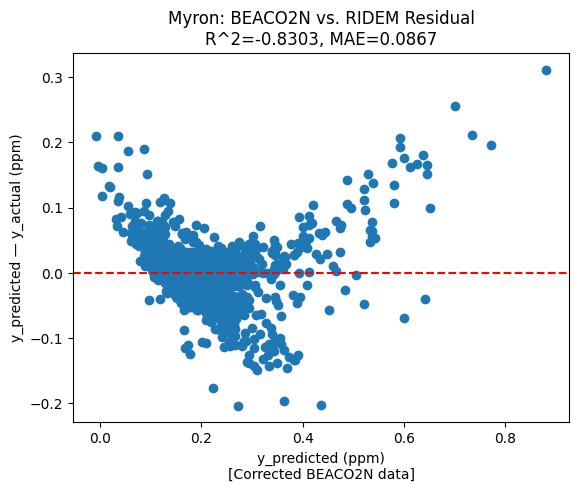

In [98]:
plot = plt.scatter(y_pred_1, y_test_1 - y_pred_1)
# xmin, xmax = plt.xlim()
# plt.plot([xmin, xmax],[0,0],color='red',linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
statistics = []
statistics = {
    "Determination R^2" : r2_score(y_test_1, y_pred_1),
    "Correlation r" : np.corrcoef(y_test_1, y_pred_1)[0,1], 
    "RMSE" : np.sqrt(np.mean((y_test_1-y_pred_1)**2)), 
    "MAE" : mean_absolute_error(y_test_1, y_pred_1), 
    "Intercept" : model_1.intercept_,
    "co_coef" : model_1.coef_[0],
    "temp_coef" : model_1.coef_[1],
    "rh_coef" : model_1.coef_[2], 
    'n' : len(y_test_1) 
}
plt.title(f"Myron: BEACO2N vs. RIDEM Residual\nR^2={statistics['Determination R^2']:.4f}, MAE={statistics['MAE']:.4f}")
plt.xlabel("y_predicted (ppm)\n[Corrected BEACO2N data]")
plt.ylabel("y_predicted — y_actual (ppm)")
plt.savefig("./model_predictions/myron/model_1.png")
pd.DataFrame(statistics, index=[1]).T.to_csv("./model_predictions/myron/model_1_stats.csv")

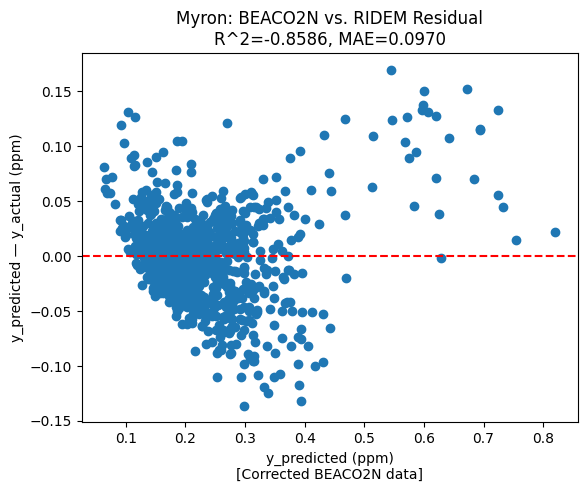

In [99]:
plot = plt.scatter(y_pred_2, y_test_2 - y_pred_2)
# xmin, xmax = plt.xlim()
# plt.plot([xmin, xmax],[0,0],color='red',linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
statistics = []
statistics = {
    "Determination R^2" : r2_score(y_test_2, y_pred_2),
    "Correlation r" : np.corrcoef(y_test_2, y_pred_2)[0,1], 
    "RMSE" : np.sqrt(np.mean((y_test_2-y_pred_2)**2)), 
    "MAE" : mean_absolute_error(y_test_2, y_pred_2), 
    "Intercept" : model_2.intercept_,
    "co_coef" : model_2.coef_[0],
    "temp_coef" : model_2.coef_[1],
    "rh_coef" : model_2.coef_[2], 
    'n' : len(y_test_2) 
}

plt.title(f"Myron: BEACO2N vs. RIDEM Residual\nR^2={statistics['Determination R^2']:.4f}, MAE={statistics['MAE']:.4f}")
plt.xlabel("y_predicted (ppm)\n[Corrected BEACO2N data]")
plt.ylabel("y_predicted — y_actual (ppm)")
plt.savefig("./model_predictions/myron/model_2.png")
pd.DataFrame(statistics, index=[1]).T.to_csv("./model_predictions/myron/model_2_stats.csv")

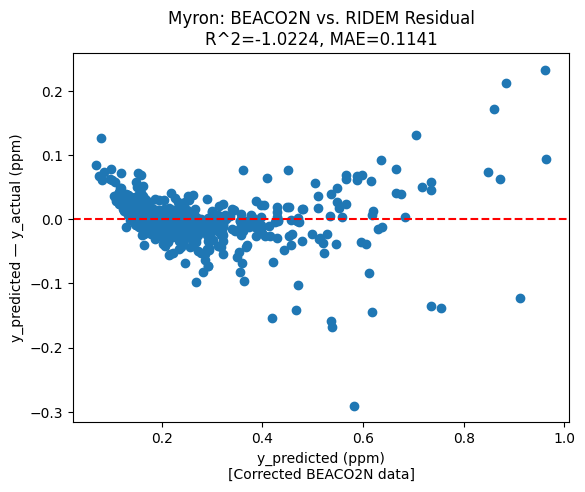

In [100]:
plot = plt.scatter(y_pred_3, y_test_3 - y_pred_3)
# xmin, xmax = plt.xlim()
# plt.plot([xmin, xmax],[0,0],color='red',linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
statistics = []
statistics = {
    "Determination R^2" : r2_score(y_test_3, y_pred_3),
    "Correlation r" : np.corrcoef(y_test_3, y_pred_3)[0,1], 
    "RMSE" : np.sqrt(np.mean((y_test_3-y_pred_3)**2)), 
    "MAE" : mean_absolute_error(y_test_3, y_pred_3), 
    "Intercept" : model_3.intercept_,
    "co_coef" : model_3.coef_[0],
    "temp_coef" : model_3.coef_[1],
    "rh_coef" : model_3.coef_[2], 
    'n' : len(y_test_3) 
}

plt.title(f"Myron: BEACO2N vs. RIDEM Residual\nR^2={statistics['Determination R^2']:.4f}, MAE={statistics['MAE']:.4f}")
plt.xlabel("y_predicted (ppm)\n[Corrected BEACO2N data]")
plt.ylabel("y_predicted — y_actual (ppm)")
plt.savefig("./model_predictions/myron/model_3.png")
pd.DataFrame(statistics, index=[1]).T.to_csv("./model_predictions/myron/model_3_stats.csv")